# Fast rank-one updates to matrix inverse?

Let $A \in \mathbb{R}^{n \times n}$. The [Sherman–Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) suggests a computational shortcut to update a matrix inverse subject to a rank-one update, i.e., an additive change of the form $A + u \, v^\top$ where $u, v \in \mathbb{R}^n$:

$$
(A + u \, v^\top)^{-1}
$$

Suppose we have precomputed $B = A^{-1}$, the shortcut is
$$
(A + u \, v^\top)^{-1} = B^{-1} - \frac{1}{1 + v^\top B\, u} B\, u\, v^\top B 
$$

Implemented carefully, it runs in $\mathcal{O}(n^2)$, which is better than $\mathcal{O}(n^3)$ from scratch.  Ok, *technically* matrix inversion can run faster than cubic, but you get my point.

Below is a direct translation of equations into numpy, but It does NOT run in $\mathcal{O}(n^2)$. 


Do you see why?

In [1]:
import numpy as np, scipy
from numpy.linalg import inv

def slowest(A,B,u,c):
    return inv(A + np.outer(u, v))

def slow(A,B,u,v):
    return B - B @ u @ v.T @ B / (1 + v.T @ B @ u)

def fast(A,B,u,v):
    return B - (B @ u) @ (v.T @ B) / (1 + v.T @ B @ u)

In [2]:
from arsenal import iterview, timers
def workload():
    for n in iterview(np.logspace(2.5, 3.75, 10)):
        n = int(np.ceil(n))
        A = np.random.randn(n,n)
        B = inv(A)
        u = np.random.randn(n,1)
        v = np.random.randn(n,1)
        yield (n, A, B, u, v)

In [3]:
T = timers()
for (n, A, B, u, v) in workload():
    with T['slowest'](n=n):
        x = slowest(A,B,u,v)
    with T['slow'](n=n):
        y = slow(A,B,u,v)
    with T['fast'](n=n):
        z = fast(A,B,u,v)
    # pro tip: always check correctness when optimizing your code!
    assert np.allclose(x, y)
    assert np.allclose(x, z)

100.0% (10/10) [======================================================] 00:00:23


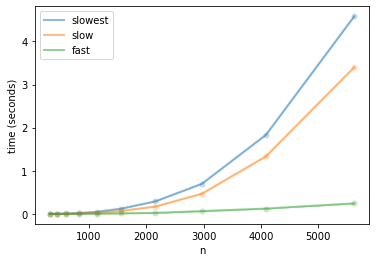

In [4]:
T.plot_feature('n');

In [5]:
T.compare()

fast is 11.2460x faster than slow (p=0.10615, mean: slow: 0.549929, fast: 0.0488998)
fast is 15.5912x faster than slowest (p=0.04449, mean: slowest: 0.762405, fast: 0.0488998)


Yikes! As you can see in the plots, the `slow` and `slowest` algorithms run at similar speeds despite all that extra effort to implement the fancy formula.  As expected, when carefully implemented, the rank-one update method is lightning fast.  

I suspect that this mistake is quite common. By default, multiplication is a left-associative operation.  This case results in an unnecessary matrix-matrix product instead of an outer-product of two matrix-vector products. 

Looking forward, I suggest that authors put explicit parenthesis in the rank-one update formula:

$$
(A + u \, v^\top)^{-1} = B^{-1} - \frac{1}{1 + v^\top B\, u} \left(B\, u\right)\, \left(v^\top B\right)
$$


So, coders, please be careful when translating math into code.  Mathers, please help us coders out by putting parens in equations.

# Bonus

If you really want this method to be very fast, we can use specialized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) routines for rank-one updates.  Thanks to 
Dr. Nikos Karampatziakis for suggesting it on [Twitter](https://twitter.com/eigenikos/status/1375143742064062464).

Specifically, [DGER](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.blas.dger.html), which computes
$$
B \gets B + \alpha \, x\, y^\top
$$  

The following methods have a slightly different API as they do updates to $B$ *in place*.

In [6]:
def fastest(B,u,v):
    # Warning: `overwrite_a=True` silently fails when B is not an order=F array!
    assert B.flags['F_CONTIGUOUS']
    Bu = B @ u
    alpha = -1 / (1 + v.T @ Bu)
    scipy.linalg.blas.dger(alpha, Bu, v.T @ B, a=B, overwrite_a=1)

In [7]:
def faster(B,u,v):
    Bu = B @ u
    np.subtract(B, Bu @ (v.T @ B) / (1 + v.T @ Bu), out=B)

In [8]:
T = timers()
for (n, A, B, u, v) in workload():
    ref = fast(A, B, u, v)
    
    x = B.copy()
    with T['faster'](n=n):
        faster(x,u,v)
    assert np.allclose(ref, x)

    y = np.array(B.copy(), order='F', copy=True)
    with T['fastest'](n=n):
        fastest(y,u,v)
    assert np.allclose(ref, y)

100.0% (10/10) [======================================================] 00:00:12


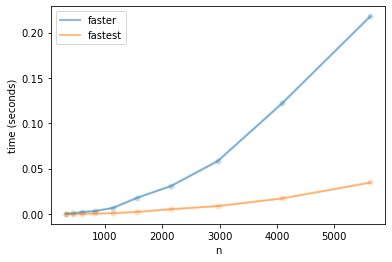

In [9]:
T.plot_feature('n');

In [10]:
T.compare()

fastest is 6.4961x faster than faster (p=0.04449, mean: faster: 0.0461405, fastest: 0.0071028)
